# Categorize nationality of last names by RNN

From http://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [121]:
import tensorflow as tf
import keras
sess = tf.InteractiveSession()

keras.__version__, tf.__version__

('2.0.2', '1.0.0')

In [9]:
! wget https://download.pytorch.org/tutorial/data.zip
! rm -R data
! unzip data.zip
! ls data

--2017-03-31 14:38:45--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org... 13.32.176.115, 13.32.176.191, 13.32.176.164, ...
Connecting to download.pytorch.org|13.32.176.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: 'data.zip.2'

data.zip.2          100%[=====================>]   2.75M  6.43MB/s   in 0.4s   

2017-03-31 14:38:46 (6.43 MB/s) - 'data.zip.2' saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japane

In [10]:
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']
Slusarski


In [11]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
n_categories

18

In [123]:
import pandas as pd

name_nations = pd.DataFrame([
    (nation,name)
    for nation, list_of_names in category_lines.items()
    for name in list_of_names], columns=['nation', 'name']
)

name_nations = name_nations\
    .assign(nation=lambda df: df.nation.astype('category'))\
    .assign(y=lambda df: df.nation.cat.codes
)

print(name_nations.nation.cat.categories)

name_nations = name_nations.sample(n=name_nations.shape[0])

name_nations.head(10)

Index(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German',
       'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish',
       'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'],
      dtype='object')


,nation,name,y
6049,English,Sampson,4
3443,English,Brunet,4
11801,Russian,Bazhaev,14
18380,Russian,Valtchikovski,14
13041,Russian,Filipiev,14
8091,Irish,Nuallan,8
18245,Russian,Vaarandi,14
8267,Italian,Albini,9
19513,Russian,Zhuravlev,14
7910,Greek,Pispinis,7


In [112]:
max_name_length = name_nations.name.apply(len).max()
max_name_length

19

In [113]:
import numpy as np

# Find letter index from all_letters, e.g. "a" = 1
# we'll reserve 0 for padding symbol
def letterToIndex(letter):
    return all_letters.find(letter) + 1

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = np.zeros(shape=(1, n_letters + 1))
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line, max_length=max_name_length):
    tensor = np.zeros(shape=(max_length, n_letters + 1))
    for li, letter in enumerate(line):
        tensor[li][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').shape)
print(np.where(lineToTensor('Jones')))

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]]
(19, 58)
(array([0, 1, 2, 3, 4]), array([36, 15, 14,  5, 19]))


In [114]:
training_seqs = np.stack([lineToTensor(name) for name in name_nations.name])
training_seqs.shape

(20074, 19, 58)

In [116]:
seq_length = max_name_length
targets = pd.get_dummies(name_nations.y).values

print(training_seqs[:3, :, 0])
print(targets[:3])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]]
[[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]]


In [126]:
from keras.layers.recurrent import LSTM, SimpleRNN
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

num_hidden = 128

model = Sequential()
model.add(
    SimpleRNN(num_hidden, input_shape=(max_name_length, n_letters + 1), 
         activation='sigmoid'))

model.add(Dense(n_categories))

model.add(Activation('softmax'))

optimizer = Adam(lr=0.005)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 128)               23936     
_________________________________________________________________
dense_7 (Dense)              (None, 18)                2322      
_________________________________________________________________
activation_8 (Activation)    (None, 18)                0         
Total params: 26,258.0
Trainable params: 26,258.0
Non-trainable params: 0.0
_________________________________________________________________


In [127]:
fit_logs = model.fit(
    training_seqs, targets, batch_size=128, epochs=100, verbose=2, validation_split=.1)

Train on 18066 samples, validate on 2008 samples
Epoch 1/100
4s - loss: 1.8876 - acc: 0.4606 - val_loss: 1.8253 - val_acc: 0.4861
Epoch 2/100
2s - loss: 1.8578 - acc: 0.4667 - val_loss: 1.8229 - val_acc: 0.4861
Epoch 3/100
2s - loss: 1.8579 - acc: 0.4667 - val_loss: 1.8116 - val_acc: 0.4861
Epoch 4/100
2s - loss: 1.8545 - acc: 0.4667 - val_loss: 1.8152 - val_acc: 0.4861
Epoch 5/100
2s - loss: 1.8544 - acc: 0.4667 - val_loss: 1.8199 - val_acc: 0.4861
Epoch 6/100
2s - loss: 1.8535 - acc: 0.4667 - val_loss: 1.8144 - val_acc: 0.4861
Epoch 7/100
2s - loss: 1.8527 - acc: 0.4667 - val_loss: 1.8184 - val_acc: 0.4861
Epoch 8/100
2s - loss: 1.8526 - acc: 0.4667 - val_loss: 1.8167 - val_acc: 0.4861
Epoch 9/100
2s - loss: 1.8213 - acc: 0.4670 - val_loss: 1.8050 - val_acc: 0.4582
Epoch 10/100
2s - loss: 1.6816 - acc: 0.4973 - val_loss: 1.5510 - val_acc: 0.5329
Epoch 11/100
2s - loss: 1.5344 - acc: 0.5396 - val_loss: 1.4685 - val_acc: 0.5608
Epoch 12/100
2s - loss: 1.4902 - acc: 0.5492 - val_loss: 1

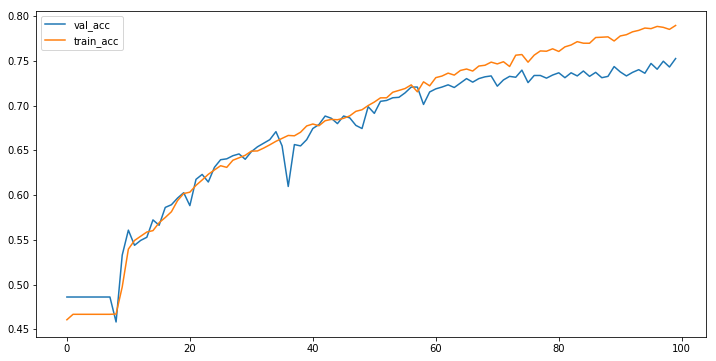

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(12, 6))
plt.plot(fit_logs.history['val_acc'], label='val_acc')
plt.plot(fit_logs.history['acc'], label='train_acc')
plt.legend();


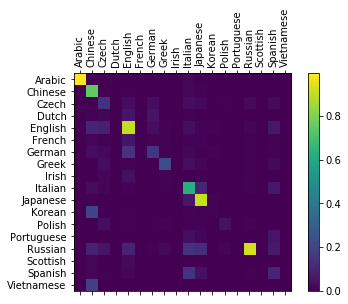

In [139]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# Keep track of correct guesses in a confusion matrix
confusion = np.zeros((n_categories, n_categories))

predicted_targets = model.predict(training_seqs, verbose=0)

for target_index, predicted_index in zip(targets.argmax(axis=1), predicted_targets.argmax(axis=1)):
    confusion[target_index][predicted_index] += 1

row_normalised_confusion = (confusion / confusion.sum(axis=1))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(row_normalised_confusion)
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [163]:
print(confusion.diagonal().sum() / confusion.sum())

0.789229849557


In [133]:
def predict_nationality(name):
    result = model.predict(np.array([lineToTensor(name)]), verbose=0)
    return np.argmax(result), name_nations.nation.cat.categories[np.argmax(result)]

In [134]:
predict_nationality("Rochefort")

(4, 'English')

In [135]:
predict_nationality("Kon")

(4, 'English')

In [136]:
predict_nationality("Satoshi")

(10, 'Japanese')

In [137]:
predict_nationality("Soldatov")

(14, 'Russian')

In [138]:
predict_nationality("Satoshi")

(10, 'Japanese')

In [142]:
predict_nationality("Infante")

(14, 'Russian')

In [161]:
model.weights[-1]

pd.DataFrame(
    model.predict(np.zeros(shape=(1, 19, 58))),
    columns=name_nations.nation.cat.categories
)



,Arabic,Chinese,Czech,Dutch,English,French,German,Greek,Irish,Italian,Japanese,Korean,Polish,Portuguese,Russian,Scottish,Spanish,Vietnamese
0,0.000018,0.579769,0.008181,0.006927,0.053793,0.007551,0.011769,0.00334,0.003083,0.012503,0.003949,0.13003,0.002718,0.001195,0.052063,0.004058,0.007593,0.11146
